# A CNN Mnist Model

In [ ]:
%install '.package(path: "$cwd/FastaiNotebook_05b_early_stopping")' FastaiNotebook_05b_early_stopping

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_05b_early_stopping")
		FastaiNotebook_05b_early_stopping
With SwiftPM flags: []
Working in: /tmp/tmp1_52coqf
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 2.68s
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'FastaiNotebook_05b_early_stopping' (8 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Loading library...
Installation complete!


## Load data

In [ ]:
import FastaiNotebook_05b_early_stopping
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
// export
import Path
import TensorFlow
import Python

In [ ]:
let plt = Python.import("matplotlib.pyplot")

In [ ]:
let data = mnistDataBunch(flat: false, bs: 512)

In [ ]:
let firstBatch = data.train.first(where: { _ in true })!
let batchShape = firstBatch.xb.shape
let batchSize = batchShape.dimensions[0]
let exampleSideSize = batchShape.dimensions[1]
assert(exampleSideSize == batchShape.dimensions[2])
print("Batch size: \(batchSize)")
print("Example side size: \(exampleSideSize)")

let classCount = firstBatch.yb.shape.dimensions[1]
print("Class count: \(classCount)")

Batch size: 512
Example side size: 28
Class count: 10


In [ ]:
struct CnnModel: Layer {
    var reshapeToSquare = Reshape<Float>([-1, exampleSideSize, exampleSideSize, 1])
    var conv1 = Conv2D<Float>(
        filterShape: (5, 5, 1, 8),
        strides: (2, 2),
        padding: .same,
        activation: relu)
    var conv2 = Conv2D<Float>(
        filterShape: (3, 3, 8, 16),
        strides: (2, 2),
        padding: .same,
        activation: relu)
    var conv3 = Conv2D<Float>(
        filterShape: (3, 3, 16, 32),
        strides: (2, 2),
        padding: .same,
        activation: relu)
    var conv4 = Conv2D<Float>(
        filterShape: (3, 3, 32, 32),
        strides: (2, 2),
        padding: .same,
        activation: relu)
    
    // The Python notebook uses "AdaptiveAvgPool2d", which I assume is different from "AvgPool2D".
    // But our layers lib only has "AvgPool2D" and that sounds good enough for now.
    var pool = AvgPool2D<Float>(poolSize: (2, 2), strides: (1, 1))
    
    var flatten = Flatten<Float>()
    var linear = Dense<Float>(inputSize: 32, outputSize: Int(classCount))
    
    @differentiable
    func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        // There isn't a "sequenced" defined with enough layers.
        let intermediate =  input.sequenced(
            in: context,
            through: reshapeToSquare, conv1, conv2, conv3, conv4)
        return intermediate.sequenced(in: context, through: pool, flatten, linear)
    }
}

In [ ]:
// Test that data goes through the model as expected.
let predictions = CnnModel().applied(to: firstBatch.xb, in: Context(learningPhase: .training))
print(predictions.shape)
print(predictions[0])

TensorShape(dimensions: [512, 10])
[-0.0023781073, -0.018652549, 0.006380776, -0.005592445, 0.0011462932, 0.003980713, 0.0036438187, -0.004035686, 0.019292789, 0.012610113]


# Compare training on CPU and GPU

In [ ]:
let opt = SGD<CnnModel, Float>(learningRate: 0.4)
func modelInit() -> CnnModel { return CnnModel() }

// TODO: When TF-421 is fixed, switch back to the normal `softmaxCrossEntropy`.

@differentiable(vjp: _vjpSoftmaxCrossEntropy)
func softmaxCrossEntropy1<Scalar: TensorFlowFloatingPoint>(
    _ features: Tensor<Scalar>, _ labels: Tensor<Scalar>
) -> Tensor<Scalar> {
    return Raw.softmaxCrossEntropyWithLogits(features: features, labels: labels).loss.mean()
}

@usableFromInline
func _vjpSoftmaxCrossEntropy<Scalar: TensorFlowFloatingPoint>(
    features: Tensor<Scalar>, labels: Tensor<Scalar>
) -> (Tensor<Scalar>, (Tensor<Scalar>) -> (Tensor<Scalar>, Tensor<Scalar>)) {
    let (loss, grad) = Raw.softmaxCrossEntropyWithLogits(features: features, labels: labels)
    let batchSize = Tensor<Scalar>(features.shapeTensor[0])
    return (loss.mean(), { v in ((v / batchSize) * grad, Tensor<Scalar>(0)) })
}

let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])

In [ ]:
// This happens on the GPU (if you have one and it's configured correctly).
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~4.3s
// - nvidia-smi shows ~10% GPU-Util while this is running
time {
    try! learner.fit(1)
}

Epoch 0: [0.34844986, 0.8913]                                                   
5381.266521 ms                                                                


In [ ]:
// This happens on the CPU.
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~6.3s
// - nvidia-smi shows 0% GPU-Util while this is running
time {
    withDevice(.cpu) {
        try! learner.fit(1)
    }
}

Epoch 0: [0.19503687, 0.942]                                                    
11353.331143 ms                                                               


# Collect Layer Activation Statistics

In [ ]:
class LayerDelegate {
    func layer(_ name: String, didProduceActivation activation: Tensor<Float>, in context: Context) {}
}

// TODO: This should not be a global. Maybe we can put it in Context?
var layerDelegates: [LayerDelegate] = []

struct DelegatingLayer<L: Layer>: Layer
    where L.Output == Tensor<Float>,
          L.CotangentVector == L.AllDifferentiableVariables
{
    @noDerivative let name: String
    var layer: L
    
    init(_ name: String, _ layer: L) {
        self.name = name
        self.layer = layer
    }
    
    @differentiable
    func applied(to input: L.Input, in context: Context) -> L.Output {
        let activation = layer.applied(to: input, in: context)
        
        // Need to wrap this in a closure to prevent AD from seeing control flow.
        ({
            layerDelegates.forEach { $0.layer(name, didProduceActivation: activation, in: context) }
        })()
        
        return activation
    }
}

In [ ]:
struct CnnModelWithDelegates: Layer {
    var reshape = Reshape<Float>([-1, exampleSideSize, exampleSideSize, 1])

    var conv1 = DelegatingLayer(
        "conv1",
        Conv2D<Float>(filterShape: (5, 5, 1, 8), strides: (2, 2), padding: .same, activation: relu))
    
    var conv2 = DelegatingLayer(
        "conv2",
        Conv2D<Float>(filterShape: (3, 3, 8, 16), strides: (2, 2), padding: .same, activation: relu))
        
    var conv3 = DelegatingLayer(
        "conv3",
        Conv2D<Float>(filterShape: (3, 3, 16, 32), strides: (2, 2), padding: .same, activation: relu))
        
    var conv4 = DelegatingLayer(
        "conv4",
        Conv2D<Float>(filterShape: (3, 3, 32, 32), strides: (2, 2), padding: .same, activation: relu))
    
    // The Python notebook uses "AdaptiveAvgPool2d", which I assume is different from "AvgPool2D".
    // But our layers lib only has "AvgPool2D" and that sounds good enough for now.
    var pool = DelegatingLayer(
        "pool",
        AvgPool2D<Float>(poolSize: (2, 2), strides: (1, 1)))
    
    var flatten = Flatten<Float>()
        
    var linear = DelegatingLayer(
        "linear",
        Dense<Float>(inputSize: 32, outputSize: Int(classCount)))
    
    @differentiable
    func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        // There isn't a "sequenced" defined with enough layers.
        let intermediate =  input.sequenced(
            in: context,
            through: reshape, conv1, conv2, conv3, conv4)
        return intermediate.sequenced(in: context, through: pool, flatten, linear)
    }
}

In [ ]:
class ActivationStatistics: LayerDelegate {
    var activationMeans: [String: [Float]] = [:]
    var activationStds: [String: [Float]] = [:]    
    override func layer(_ name: String, didProduceActivation activation: Tensor<Float>, in context: Context) {
        guard context.learningPhase == .training else { return }
        activationMeans[name, default: []].append(activation.mean().scalar!)
        activationStds[name, default: []].append(activation.standardDeviation().reshaped(to: []).scalar!)
    }
}
layerDelegates.append(ActivationStatistics())

In [ ]:
let opt = SGD<CnnModelWithDelegates, Float>(learningRate: 0.4)
func modelInit() -> CnnModelWithDelegates { return CnnModelWithDelegates() }
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])

In [ ]:
// This LayerDelegate stuff slows it down to ~6s/epoch.
time {
    try! learner.fit(2)
}

Epoch 0: [0.3989277, 0.8809]                                                    
Epoch 1: [0.20191155, 0.9393]                                                   
13309.413396 ms                                                               


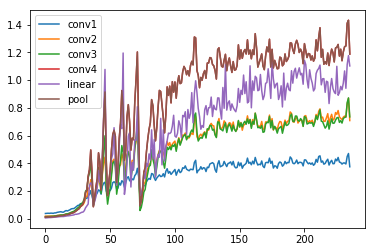

None


In [ ]:
let activationStatistics = layerDelegates[0] as! ActivationStatistics
var names: [String] = []
for name in activationStatistics.activationMeans.keys.sorted() {
    plt.plot(activationStatistics.activationMeans[name])
    names.append(name)
}
plt.legend(names)
plt.show()

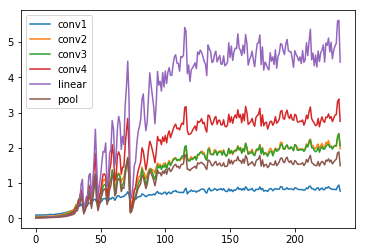

None


In [ ]:
var names: [String] = []
for name in activationStatistics.activationStds.keys.sorted() {
    plt.plot(activationStatistics.activationStds[name])
    names.append(name)
}
plt.legend(names)
plt.show()

## Export

In [ ]:
notebookToScript(fname: (Path.cwd / "06_cuda.ipynb").string)